# 电磁式阻尼器振动控制训练
本notebook用于训练基于GRUA网络架构的TD3算法，用于电磁式阻尼器的振动控制，

### 主要特点
- 使用TD3（Twin Delayed Deep Deterministic Policy Gradient）作为基础算法
- 输入时间序列，支持延时
- 针对电磁式阻尼器系统的振动控制优化

## 训练环境与项目日志初始化

In [1]:
import numpy as np
import torch
import json  # 导入json模块
import logging

from data import plot_data, format_dict, make_dirs

train_model = True  # 是否训练模型
controller_type = "PPO" # 控制器类型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from datetime import datetime
import os
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
project_name = input("请输入加载/创建项目的名称 (父目录: .\\savedata) ").strip()# 创建保存模型的基础目录
project_path, ckpt_dir, plt_dir = make_dirs(project_name)
file_path = os.path.join(project_path, f'training_{current_time}.log')
logging.basicConfig(filename=file_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", project_path)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("使用设备: %s", device)
print(f"日志文件: {file_path}")

日志文件: savedata\20260114PPO全连接全观测训练，无时延，初位移条件\training_20260114_155546.log


## 训练参数

In [3]:
from fx import tolerance_reward, zero

ENV_PARAMS = {
    'Ts': 0.001,  # 环境时间步长
    'T': 1.0,     # 每回合总时间
    'state0': np.array([0.0, 0.0, 0.0, 0.006, 0.0, 0.0]),  # 初始状态
    'obs_indices': [0, 1, 2, 3, 4, 5],  # 观测状态索引
    'x1_limit': 0.03,  # 状态 x1 的限制
    'use_dt_noise': False,  # 是否使用时间步长噪声
    'dt_noise_std': 0.1,  # 时间步长噪声标准差
    'delay_enabled': False,  # 是否启用动作延迟
    'delay_mean_steps': 0,  # 延迟均值步数
    'delay_std_steps': 0,   # 延迟标准差步数
    'include_dt_in_obs': False,  # 是否在观测中包含时间步长
    'include_delay_in_obs': True,  # 是否在观测中包含延迟
    'z_func': zero,  # 状态惩罚函数
    'r_func': tolerance_reward(1e-3),  # 奖励函数
    'f_func': zero,  # 外部激励函数
}

PPO_PARAMS = {
    'arch': 'mlp',
    'norm': False,
    'simple_nn': False,
    'state_dim': len(ENV_PARAMS['obs_indices']) + int(ENV_PARAMS['include_dt_in_obs']) + int(ENV_PARAMS['include_delay_in_obs']),
    'action_dim': 1,
    'action_bound': 5.0,
    'gru_hidden': 64,    
    'gru_layers': 1,
    'hidden_dim': 128,
    'seq_len': 32,
    'fc_seq_len': 4,
    'actor_lr': 3e-4,
    'critic_lr': 1e-3,
    'gamma': 0.99, # 折扣因子
    'gae_lambda': 0.95, # GAE lambda 参数
    'clip_epsilon': 0.2, # PPO 裁剪系数
    'entropy_coef': 0.01, # 熵正则化系数
    'value_loss_coef': 0.5, # 价值损失系数
    'max_grad_norm': 0.5, # 梯度裁剪阈值
    'n_epochs': 4, # 每次更新的 epoch 数
    'mini_batch_size': 64, # mini-batch 
}

TRAIN_PARAMS = {
    'explore_noise_trend': 'exp',  # 探索噪声初始标准差
    'n_episodes': 500,    # 训练回合数
    'batch_size': 128,    # 训练批次大小
    'min_buffer_size': 5_000,  # 最小缓冲区大小
    'save_interval': 5,  # 模型保存间隔回合数
    'resume': True,  # 是否从检查点恢复训练
}

logging.info("环境参数:\n%s", json.dumps(format_dict(ENV_PARAMS), indent=4, ensure_ascii=False))
logging.info("PPO 参数:\n%s", json.dumps(PPO_PARAMS, indent=4, ensure_ascii=False))
logging.info("训练参数:\n%s", json.dumps(TRAIN_PARAMS, indent=4, ensure_ascii=False))

## 初始化环境、控制器、经验池

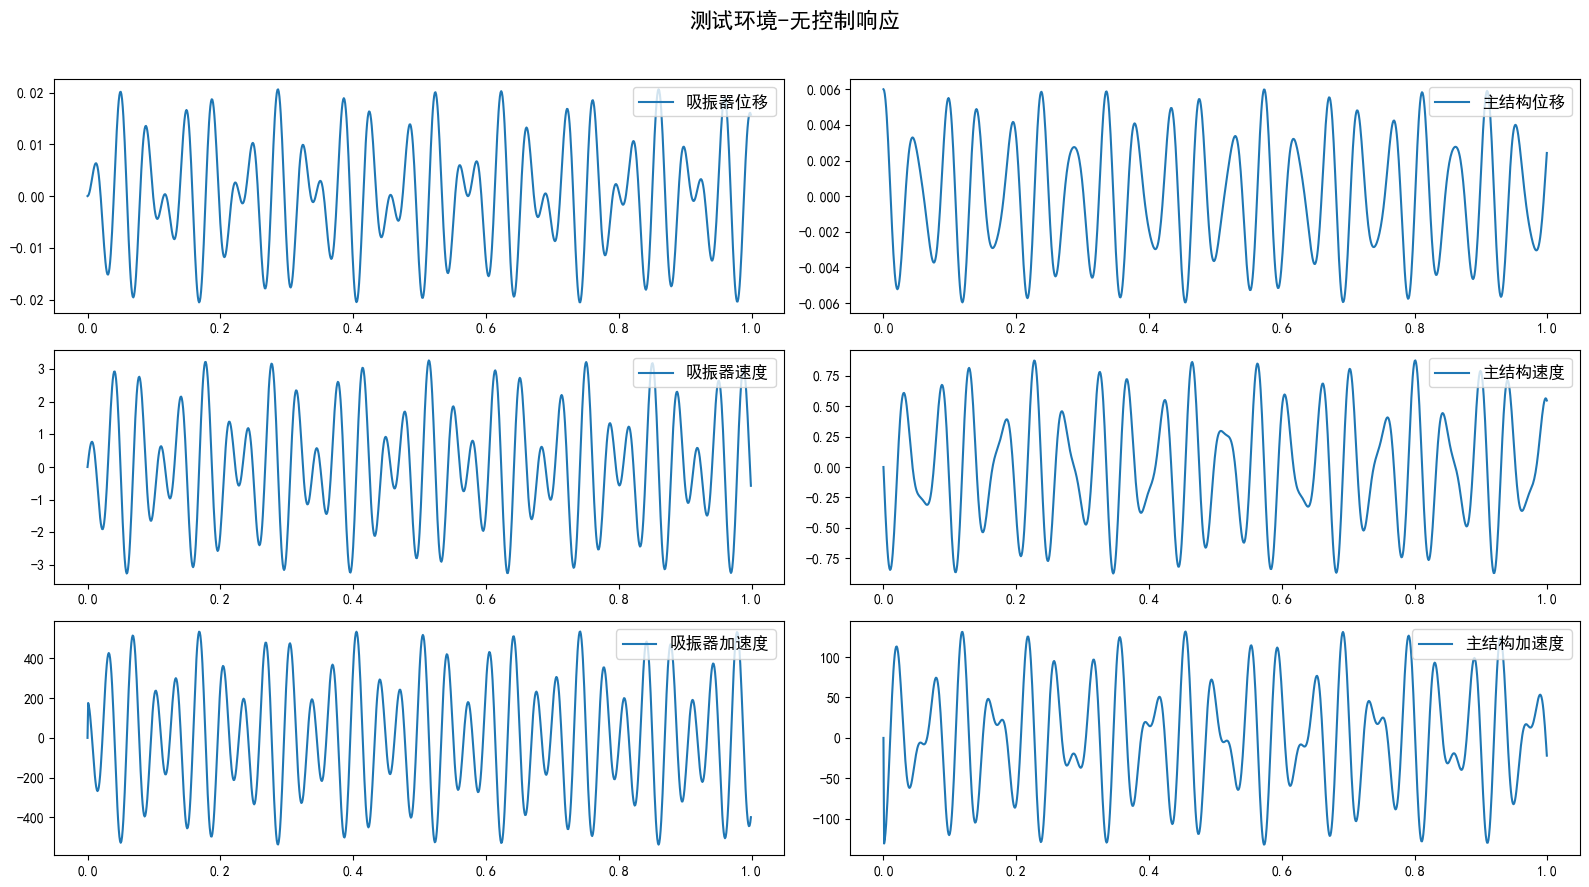

In [4]:
from env import build_env
test_env = build_env(ENV_PARAMS)
test_recorder = test_env.run_episode(record=True)
x_values=test_recorder.as_numpy(keys='time_history').reshape(-1, 1)
y_values=test_recorder.as_numpy(keys='state_history')[:,[0,1,2,3,4,5]]
plot_data(x_values=x_values, y_values=y_values, legends=[('吸振器位移',),('主结构位移',),('吸振器速度',),('主结构速度',),('吸振器加速度',),('主结构加速度',)], sub_shape=(3,2),
          sub_group=[(0,),(3,),(1,),(4,),(2,),(5,)],plot_title='测试环境-无控制响应',legend_loc='upper right')

In [5]:
from controller import build_controller

controller = build_controller(PPO_PARAMS, type=controller_type)

logging.info("Actor 网络结构:\n%s", controller.actor)
logging.info("Critic 网络结构:\n%s", controller.critic)

In [6]:
from buffer import ReplayBuffer
replay_buffer = ReplayBuffer(state_dim=PPO_PARAMS['state_dim'], capacity=50_000,)

## 训练

In [7]:
if train_model:
    from train import train
    train(project_name=project_name, 
          env=build_env(ENV_PARAMS), controller=controller, buffer=replay_buffer, 
          explore_noise_trend=TRAIN_PARAMS['explore_noise_trend'], n_episodes=TRAIN_PARAMS['n_episodes'],
          batch_size=TRAIN_PARAMS['batch_size'], min_buffer_size=TRAIN_PARAMS['min_buffer_size'], 
          save_interval=TRAIN_PARAMS['save_interval'],resume=TRAIN_PARAMS.get('resume', False))

100%|██████████| 499/499 [6:31:32<00:00, 47.08s/it]  

Training finished.
